In [27]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, brier_score_loss
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime

In [ ]:
raw_data = pd.read_csv('data/pitcher_subset.csv')

In [38]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148535 entries, 0 to 148534
Data columns (total 38 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   gameid            148535 non-null  object 
 1   GameDate.x        148535 non-null  object 
 2   ab                148535 non-null  int64  
 3   pitchnum          148535 non-null  int64  
 4   inning            148535 non-null  int64  
 5   teambat           148535 non-null  int64  
 6   balls             148535 non-null  int64  
 7   strikes           148535 non-null  int64  
 8   outs              148535 non-null  int64  
 9   pitcher           148535 non-null  object 
 10  pitcherthrows     148535 non-null  object 
 11  batter            148535 non-null  object 
 12  batterside        148535 non-null  object 
 13  pitchresult       148535 non-null  object 
 14  pitchresult_desc  148535 non-null  object 
 15  eventtype         148535 non-null  object 
 16  pitchname         14

# Feature Building

In [247]:
data = raw_data.copy()
data['GameDate'] = pd.to_datetime(data['GameDate'])
data = data.sort_values(['GameDate', 'gameid', 'ab', 'pitchnum'])

data['pitch_type'] = data['pitch_type'].map({'Breaking Ball': 0, 'Fastball':1}) #Response

Last Pitch / Pattern Recognition

In [248]:
data['prev_pitch'] = data['pitch_type'].shift(-1)
data['prev_result'] = data['eventtype'].shift(-1)

data.loc[(data['pitchnum'] == 1), 'last_pitch_na'] = 1
data['last_pitch_na'] = data['last_pitch_na'].fillna(0)

data.loc[(data['last_pitch_na'] == 0) & (data['prev_pitch'] == 1), 'last_pitch_fastball'] = 1
data['last_pitch_fastball'] = data['last_pitch_fastball'].fillna(0)

data.loc[(data['last_pitch_na'] == 0) & ((data['eventtype'] == "called_strike") | (data['eventtype'] == "swinging_strike") | (data['eventtype'] == "foul")), 'last_pitch_strike'] = 1
data['last_pitch_strike'] = data['last_pitch_strike'].fillna(0)

Leverage

In [249]:
data['score_diff'] = np.where(data['teambat'] == 0, data['homscore'] - data['visscore'], data['visscore'] - data['homscore'])

data['in_scoring_position'] = data[['r2bool', 'r3bool']].max(axis=1)
data = data.rename({'r1bool':'on_first_base'}, axis=1)

data['inning_weight'] = (data['inning']-1) // 3 + 1
data.loc[data['inning_weight'] > 3, 'inning_weight'] = 3.0

data['r2bool'] = data['r2bool'].astype('bool')
data['r3bool'] = data['r3bool'].astype('bool')
data['on_first_base'] = data['on_first_base'].astype('bool')

data.loc[(data['on_first_base'] & ~data['r2bool'] & ~data['r3bool']), 'base_factor'] = 1.5
data.loc[(data['r2bool'] ^ data['r3bool'] & ~data['on_first_base']), 'base_factor'] = 2.0
data.loc[(data['r2bool'] & data['on_first_base'] & ~data['r3bool']) | (data['r3bool'] & data['on_first_base'] & ~data['r2bool']), 'base_factor'] = 2.25
data.loc[(data['r2bool'] & ~data['on_first_base'] & data['r3bool']), 'base_factor'] = 2.5
data.loc[(data['r2bool'] & data['on_first_base'] & data['r3bool']), 'base_factor'] = 2.75
data['base_factor'] = data['base_factor'].fillna(1.0)

data['leverage'] = data['inning_weight'] * (1 / (np.abs(data['score_diff']) + 1)) * data['base_factor']

Platoon Splits

In [250]:
data['balls_strikes'] = data['balls'].astype(int).astype(str) + '_' + data['strikes'].astype(int).astype(str)
data.loc[(data['batterside'] == 'L') & (data['pitcherthrows'] == 'L'), 'platoon_l_l'] = 1.0
data['platoon_l_l'] = data['platoon_l_l'].fillna(0.0)
data.loc[(data['batterside'] == 'R') & (data['pitcherthrows'] == 'R'), 'platoon_r_r'] = 1.0
data['platoon_r_r'] = data['platoon_r_r'].fillna(0.0)
data.loc[(data['batterside'] == 'L') & (data['pitcherthrows'] == 'R'), 'platoon_l_r'] = 1.0
data['platoon_l_r'] = data['platoon_l_r'].fillna(0.0)

Batting Counts

In [251]:
one_hot_df = pd.get_dummies(data['balls_strikes'], prefix='Count', dtype=int)
data = pd.concat([data, one_hot_df], axis=1)

In [252]:
data['batter_count'] = data[['Count_2_0', 'Count_3_0', 'Count_3_1']].max(axis=1)
data['batter_count'] = data['batter_count'].fillna(0.0)
data['neutral_count'] = data[['Count_0_1', 'Count_1_0', 'Count_0_0', 'Count_1_1', 'Count_2_1', 'Count_3_2']].max(axis=1) 
data['neutral_count'] = data['neutral_count'].fillna(0.0)
data['pitcher_count'] = data[['Count_0_2', 'Count_2_2', 'Count_1_2']].max(axis=1)
data['pitcher_count'] = data['pitcher_count'].fillna(0.0)

Feature List

In [253]:
data.columns

Index(['gameid', 'GameDate', 'ab', 'pitchnum', 'inning', 'teambat', 'balls',
       'strikes', 'outs', 'pitcher', 'pitcherthrows', 'batter', 'batterside',
       'pitchresult', 'pitchresult_desc', 'eventtype', 'pitchname',
       'pitchname_desc', 'spinrate', 'relspeed', 'horzbreak',
       'inducedvertbreak', 'platelocside', 'platelocheight', 'hometeam_id',
       'Home', 'awayteam_id', 'Visitor', 'venue_id', 'venue_name', 'year',
       'visscore', 'homscore', 'on_first_base', 'r2bool', 'r3bool',
       'pitch_type', 'prev_pitch', 'prev_result', 'last_pitch_na',
       'last_pitch_fastball', 'last_pitch_strike', 'score_diff',
       'in_scoring_position', 'inning_weight', 'base_factor', 'leverage',
       'balls_strikes', 'platoon_l_l', 'platoon_r_r', 'platoon_l_r',
       'Count_0_0', 'Count_0_1', 'Count_0_2', 'Count_1_0', 'Count_1_1',
       'Count_1_2', 'Count_2_0', 'Count_2_1', 'Count_2_2', 'Count_3_0',
       'Count_3_1', 'Count_3_2', 'batter_count', 'neutral_count',
       'pit

# Modeling

Feature Selection

In [265]:
log_reg_df = data[['pitch_type', 'GameDate', 'pitcher', 'batter', 'ab', 'pitchnum', 
       'Count_0_1', 'Count_0_2', 'Count_2_1',
       'Count_1_0', 'Count_1_1', 'Count_1_2', 'Count_2_0', 'Count_2_2', 'Count_3_1',
       'Count_3_0', 'batter_count', 'neutral_count', 'pitcher_count']].copy()

Player-Specific Features and train/test split

In [255]:
log_reg_df['pitch_type'].mean()

0.5881208645490466

In [266]:
train = log_reg_df[log_reg_df['GameDate'] < '2023-06-15'] #~81% of data before this date

historical_rates = train.copy()

#calculation for naive model to compare
naive_historical_rates = historical_rates.groupby(['pitcher'])['pitch_type'].agg(['sum', 'count']).reset_index()
naive_historical_rates['naive_historical_rate'] = naive_historical_rates['sum'] / naive_historical_rates['count']
naive_historical_rates = naive_historical_rates.drop(['count', 'sum'], axis=1)

#Pitcher Fastball rate when up in count
pitcher_fb_rate_batter_count = historical_rates[historical_rates['batter_count'] == 1.0].groupby('pitcher')['pitch_type'].agg(['sum', 'count']).reset_index()
pitcher_fb_rate_batter_count['sum'] += 59/4 #beta binomial with B(59/4, 25) as prior (to pull rates closer to mean of 59%)
pitcher_fb_rate_batter_count['count'] += 100/4
pitcher_fb_rate_batter_count = pitcher_fb_rate_batter_count.rename({'sum':'b_sum', 'count':'b_count'}, axis=1)
pitcher_fb_rate_batter_count['pitcher_fb_rate_batter_count'] = pitcher_fb_rate_batter_count['b_sum'] / pitcher_fb_rate_batter_count['b_count']

#Pitcher Fastball rate when down in count
pitcher_fb_rate_pitcher_count = historical_rates[historical_rates['pitcher_count'] == 1.0].groupby('pitcher')['pitch_type'].agg(['sum', 'count']).reset_index()
pitcher_fb_rate_pitcher_count['sum'] += 59/4
pitcher_fb_rate_pitcher_count['count'] += 100/4
pitcher_fb_rate_pitcher_count = pitcher_fb_rate_pitcher_count.rename({'sum':'p_sum', 'count':'p_count'}, axis=1)
pitcher_fb_rate_pitcher_count['pitcher_fb_rate_pitcher_count'] = pitcher_fb_rate_pitcher_count['p_sum'] / pitcher_fb_rate_pitcher_count['p_count']


train = pd.merge(train, pitcher_fb_rate_batter_count, on ='pitcher')
train = pd.merge(train, pitcher_fb_rate_pitcher_count, on ='pitcher')
train = pd.merge(train, naive_historical_rates, on ='pitcher')

#Batter Fastball rate when up in count
batter_fb_rate_batter_count = historical_rates[historical_rates['batter_count'] == 1.0].groupby('batter')['pitch_type'].agg(['count', 'sum']).reset_index()
batter_fb_rate_batter_count['sum'] += 59/4
batter_fb_rate_batter_count['count'] += 100/4
batter_fb_rate_batter_count = batter_fb_rate_batter_count.rename({'sum':'bat_b_sum', 'count':'bat_b_count'}, axis=1)
batter_fb_rate_batter_count['batter_fb_rate_batter_count'] = batter_fb_rate_batter_count['bat_b_sum'] / batter_fb_rate_batter_count['bat_b_count']

#Batter Fastball rate when down in count
batter_fb_rate_pitcher_count = historical_rates[historical_rates['pitcher_count'] == 1.0].groupby('batter')['pitch_type'].agg(['count', 'sum']).reset_index()
batter_fb_rate_pitcher_count['sum'] += 59/4
batter_fb_rate_pitcher_count['count'] += 100/4
batter_fb_rate_pitcher_count = batter_fb_rate_pitcher_count.rename({'sum':'bat_p_sum', 'count':'bat_p_count'}, axis=1)
batter_fb_rate_pitcher_count['batter_fb_rate_pitcher_count'] = batter_fb_rate_pitcher_count['bat_p_sum'] / batter_fb_rate_pitcher_count['bat_p_count']

train = pd.merge(train, batter_fb_rate_batter_count, on = 'batter')
train = pd.merge(train, batter_fb_rate_pitcher_count, on = 'batter')

#drop all non-used columns that aren't the counts (need to pass these to test to dynamically update historical rates)
X_train = train.drop(['pitch_type', 'GameDate', 'batter', 'pitcher', 'b_count', 'b_sum', 'ab', 'pitchnum', 'naive_historical_rate', 'batter_count', 'pitcher_count',
                      'neutral_count', 'bat_b_sum', 'bat_b_count', 'p_count', 'p_sum', 'bat_p_sum', 'bat_p_count'], axis=1)
feature_names = X_train.columns
y_train = train[['pitch_type']]

In [267]:
test = log_reg_df[log_reg_df['GameDate'] >= '2023-06-15'] #~19% of data after this date

#join with test data to provide prior before updating rates as pitches come in
test= pd.merge(test, naive_historical_rates, on ='pitcher', how='left')
test= pd.merge(test, pitcher_fb_rate_batter_count, on ='pitcher', how='left')
test= pd.merge(test, pitcher_fb_rate_pitcher_count, on ='pitcher', how='left')
test= pd.merge(test, batter_fb_rate_batter_count, on ='batter', how='left')
test= pd.merge(test, batter_fb_rate_pitcher_count, on ='batter', how='left')

#fill pitchers who don't have any data in the train set with averages 
test[['b_count',  'bat_b_count', 'bat_p_count', 'p_count']] = test[['b_count',  'bat_b_count', 'bat_p_count', 'p_count']].fillna(100/4)
test[['b_sum','bat_b_sum', 'bat_p_sum', 'p_sum']] = test[['b_sum','bat_b_sum', 'bat_p_sum', 'p_sum']].fillna(59/4)
test = test.sort_values(['pitcher', 'GameDate', 'ab', 'pitchnum'])

#create cummalative counts to update rates as data comes in
test['b_cumcount'] = test.groupby(['pitcher', 'batter_count']).cumcount() + 1
test['b_cumsum'] = test.groupby(['pitcher', 'batter_count'])['pitch_type'].cumsum()


test['p_cumcount'] = test.groupby(['pitcher', 'pitcher_count']).cumcount() + 1
test['p_cumsum'] = test.groupby(['pitcher', 'pitcher_count'])['pitch_type'].cumsum()

test['bat_b_cumcount'] = test.groupby(['batter', 'batter_count']).cumcount() + 1
test['bat_b_cumsum'] = test.groupby(['batter', 'batter_count'])['pitch_type'].cumsum()

test['bat_p_cumcount'] = test.groupby(['batter', 'pitcher_count']).cumcount() + 1
test['bat_p_cumsum'] = test.groupby(['batter', 'pitcher_count'])['pitch_type'].cumsum()

test['pitcher_fb_rate_batter_count'] = (test['b_cumsum'] + test['b_sum']) / (test['b_count'] + test['b_cumcount'])
test['pitcher_fb_rate_pitcher_count'] = (test['p_cumsum'] + test['p_sum']) / (test['p_count'] + test['p_cumcount'])
test['batter_fb_rate_batter_count'] = (test['bat_b_cumsum'] + test['bat_b_sum']) / (test['bat_b_count'] + test['bat_b_cumcount'])
test['batter_fb_rate_pitcher_count'] = (test['bat_p_cumsum'] + test['bat_p_sum']) / (test['bat_p_count'] + test['bat_p_cumcount'])

X_test = test.drop(['pitch_type', 'GameDate', 'batter', 'pitcher', 'b_count', 'b_sum', 'b_cumsum', 'b_cumcount', 
                     'bat_b_cumsum', 'bat_b_cumcount', 'bat_b_sum', 'bat_b_count', 'p_count', 'p_sum', 'p_cumsum', 'p_cumcount',
                    'ab', 'pitchnum', 'naive_historical_rate', 'batter_count', 'neutral_count', 'pitcher_count', 'bat_p_sum', 'bat_p_count',
                    'bat_p_cumcount', 'bat_p_cumsum'
                    ], axis=1)
y_test = test[['pitch_type']]

In [258]:
train.to_csv('train_data.csv', index=False)
test.to_csv('test_data.csv', index=False)

In [268]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
vif["Feature"] = X_train.columns
print(vif)

          VIF                        Feature
0    1.409394                      Count_0_1
1    1.231273                      Count_0_2
2    1.171600                      Count_2_1
3    1.333692                      Count_1_0
4    1.322473                      Count_1_1
5    1.319622                      Count_1_2
6    1.119241                      Count_2_0
7    1.271714                      Count_2_2
8    1.077473                      Count_3_1
9    1.041202                      Count_3_0
10  37.760717   pitcher_fb_rate_batter_count
11  16.670693  pitcher_fb_rate_pitcher_count
12  69.727309    batter_fb_rate_batter_count
13  66.118998   batter_fb_rate_pitcher_count


Train Lin Reg Model and make prediction on Test set (and create naive predictions)

In [269]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)


# Create and fit the logistic regression model
model = sm.Logit(y_train, X_train)
result = model.fit()

print(result.summary())
# Predict on the test set
y_plot = result.predict(X_train)
y_pred_prob = result.predict(X_test)
y_train_pred = (y_plot >= 0.5).astype(int)
y_pred = (y_pred_prob >= 0.5).astype(int)

naive_prob = test['naive_historical_rate'].values
naive_prob[np.isnan(naive_prob)] = np.nanmean(naive_prob)
y_pred_naive = (naive_prob >= 0.5).astype(int)

Optimization terminated successfully.
         Current function value: 0.600372
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             pitch_type   No. Observations:               117328
Model:                          Logit   Df Residuals:                   117313
Method:                           MLE   Df Model:                           14
Date:                Mon, 11 Nov 2024   Pseudo R-squ.:                  0.1133
Time:                        15:09:47   Log-Likelihood:                -70440.
converged:                       True   LL-Null:                       -79439.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -4.8822      0.109    -44.656      0.

In [ ]:
y_random_prob = pd.read_csv("predicted_probs.csv")['x']
y_pred2 = (y_random_prob > 0.5).astype('int')

# Model Evaluation / Results

In [270]:
result_df = pd.concat([test['pitcher'], X_test, pd.Series(y_pred), y_test], axis=1)
result_df = result_df.rename({0:'pred_pitch'}, axis=1)
result_df['pred_prob'] = y_pred_prob
result_df['pred_prob_rand'] = y_random_prob
result_df['y_pred_rand'] = y_pred2

In [ ]:
result_df

,pitcher,const,Count_0_1,Count_0_2,Count_1_0,Count_1_1,Count_1_2,Count_2_0,Count_2_2,Count_3_1,Count_3_0,pitcher_fb_rate_batter_count,pitcher_fb_rate_pitcher_count,batter_fb_rate_batter_count,batter_fb_rate_pitcher_count,pred_pitch,pitch_type,pred_prob,pred_prob_rand,y_pred_rand
227,"Abreu, Bryan",1.0,0,0,0,0,0,0,0,0,0,0.636062,0.362113,0.690217,0.514706,0,0,0.446663,0.452720,0
228,"Abreu, Bryan",1.0,1,0,0,0,0,0,0,0,0,0.633260,0.361492,0.675532,0.508721,0,0,0.369555,0.335429,0
229,"Abreu, Bryan",1.0,0,0,0,1,0,0,0,0,0,0.630482,0.360873,0.661458,0.502874,0,0,0.368040,0.399357,0
230,"Abreu, Bryan",1.0,0,0,0,0,0,0,0,0,0,0.627729,0.360256,0.718085,0.502475,0,0,0.439199,0.293852,0
231,"Abreu, Bryan",1.0,0,0,0,0,0,0,0,0,0,0.629348,0.361348,0.633929,0.551471,0,1,0.451788,0.406099,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27122,"Wingenter, Trey",1.0,0,0,0,0,0,0,0,0,0,0.522152,0.551508,0.630282,0.640411,1,0,0.599798,0.662644,1
27123,"Wingenter, Trey",1.0,0,0,1,0,0,0,0,0,0,0.519958,0.548750,0.621528,0.631757,1,0,0.638758,0.657077,1
27124,"Wingenter, Trey",1.0,0,0,0,1,0,0,0,0,0,0.517782,0.546020,0.613014,0.623333,1,0,0.516131,0.382239,0
27125,"Wingenter, Trey",1.0,0,0,0,0,1,0,0,0,0,0.519792,0.463592,0.618243,0.659091,0,1,0.384677,0.648980,1


Scores

In [271]:
our_model = round(brier_score_loss(y_test, y_pred_prob), 4)
naive_model = round(brier_score_loss(y_test, naive_prob), 3)

print(f'Our model has a brier score of {our_model} and the naive model has a score of {naive_model}')

Our model has a brier score of 0.2047 and the naive model has a score of 0.222


In [272]:
our_model = round(roc_auc_score(y_test, y_pred_prob), 3)
naive_model = round(roc_auc_score(y_test, naive_prob), 3)

print(f'Our model has a auc score of {our_model} and the naive model has a score of {naive_model}')

Our model has a auc score of 0.732 and the naive model has a score of 0.66


Confusion Matrix

In [273]:
from sklearn import metrics
from sklearn.metrics import classification_report

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
target_names = ['breaking ball', 'fastball']
print(classification_report(y_test, y_pred, target_names=target_names))
cnf_matrix

               precision    recall  f1-score   support

breaking ball       0.60      0.60      0.60     11749
     fastball       0.71      0.71      0.71     16442

     accuracy                           0.67     28191
    macro avg       0.66      0.66      0.66     28191
 weighted avg       0.67      0.67      0.67     28191



array([[ 7082,  4667],
       [ 4735, 11707]], dtype=int64)

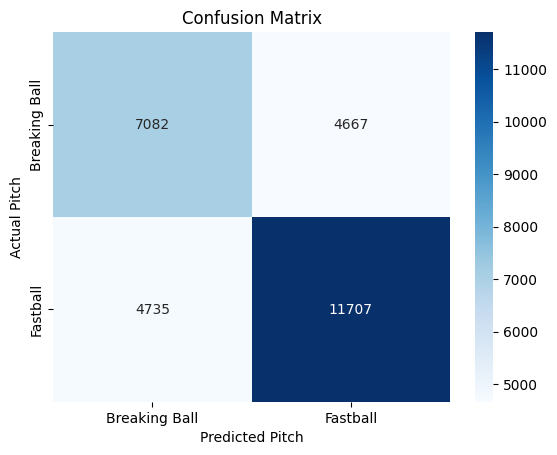

In [275]:
plt.title("Confusion Matrix")
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Breaking Ball', 'Fastball'], yticklabels=['Breaking Ball', 'Fastball'])
plt.xlabel('Predicted Pitch')
plt.ylabel('Actual Pitch')
plt.show()

ROC Curve

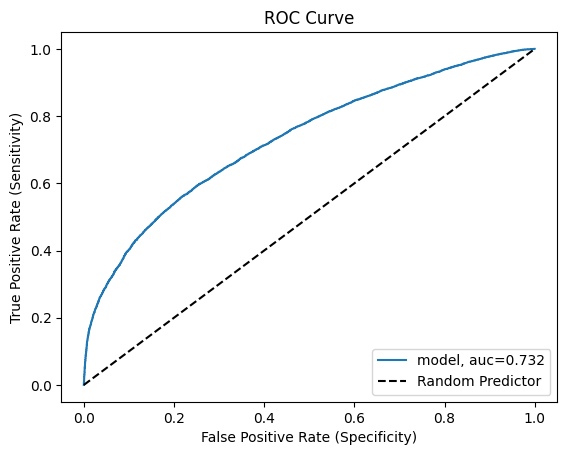

In [279]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr,tpr,label="model, auc="+str(round(auc, 3)))
plt.plot([0, 1], [0, 1], 'k--', label='Random Predictor')
plt.legend(loc=4)
plt.title("ROC Curve")
plt.xlabel('False Positive Rate (Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

Calibration

In [ ]:
result_df['prob_bin'] = pd.cut(result_df['pred_prob'], np.linspace(0, 1, 11))

C:\Users\johng\AppData\Local\Temp\ipykernel_13708\2295090214.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = result_df.groupby('prob_bin').agg(


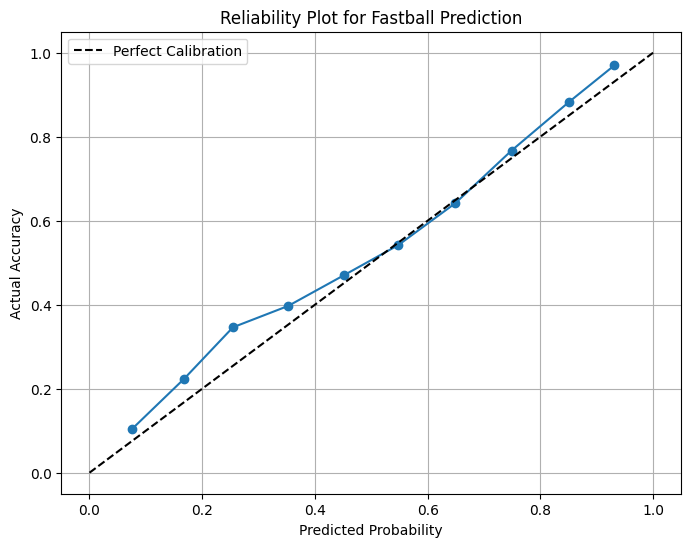

In [ ]:
bin_summary = result_df.groupby('prob_bin').agg(
    avg_pred_prob=('pred_prob', 'mean'),  
    actual_accuracy=('pitch_type', 'mean') 
).dropna() 
plt.figure(figsize=(8, 6))
plt.plot(bin_summary['avg_pred_prob'], bin_summary['actual_accuracy'], marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')

plt.xlabel('Predicted Probability')
plt.ylabel('Actual Accuracy')
plt.title('Reliability Plot for Fastball Prediction')
plt.legend()
plt.grid()
plt.show()

In [ ]:
bin_summary

,avg_pred_prob,actual_accuracy
prob_bin,,
"(0.0, 0.1]",0.585124,0.579545
"(0.1, 0.2]",0.582798,0.601423
"(0.2, 0.3]",0.575791,0.598244
"(0.3, 0.4]",0.565819,0.584771
"(0.4, 0.5]",0.562754,0.589054
"(0.5, 0.6]",0.554746,0.586375
"(0.6, 0.7]",0.561039,0.590816
"(0.7, 0.8]",0.547713,0.568994
"(0.8, 0.9]",0.545670,0.569759


Final list

In [285]:
result_df.loc[result_df['pred_pitch'] == result_df['pitch_type'], 'correct'] = 1.0
result_df['correct'] = result_df['correct'].fillna(0.0)

In [ ]:
result_df

,pitcher,Count_0_1,Count_0_2,Count_2_1,Count_3_2,Count_1_0,Count_1_1,Count_1_2,Count_2_0,Count_2_2,...,pitcher_fb_rate_pitcher_count,batter_fb_rate_batter_count,batter_fb_rate_pitcher_count,pred_pitch,pitch_type,pred_prob,pred_prob_rand,y_pred_rand,prob_bin,correct
227,"Abreu, Bryan",0,0,0,0,0,0,0,0,0,...,0.362113,0.690217,0.514706,0,0,0.434810,0.452720,0,"(0.4, 0.5]",0.0
228,"Abreu, Bryan",1,0,0,0,0,0,0,0,0,...,0.361492,0.675532,0.508721,0,0,0.371794,0.335429,0,"(0.3, 0.4]",0.0
229,"Abreu, Bryan",0,0,0,0,0,1,0,0,0,...,0.360873,0.661458,0.502874,0,0,0.369490,0.399357,0,"(0.3, 0.4]",0.0
230,"Abreu, Bryan",0,0,0,0,0,0,0,0,0,...,0.360256,0.718085,0.502475,0,0,0.454373,0.293852,0,"(0.4, 0.5]",0.0
231,"Abreu, Bryan",0,0,0,0,0,0,0,0,0,...,0.361348,0.633929,0.551471,0,1,0.378912,0.406099,0,"(0.3, 0.4]",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27122,"Wingenter, Trey",0,0,0,0,0,0,0,0,0,...,0.551508,0.630282,0.640411,1,0,0.574348,0.662644,1,"(0.5, 0.6]",0.0
27123,"Wingenter, Trey",0,0,0,0,1,0,0,0,0,...,0.548750,0.621528,0.631757,1,0,0.623221,0.657077,1,"(0.6, 0.7]",0.0
27124,"Wingenter, Trey",0,0,0,0,0,1,0,0,0,...,0.546020,0.613014,0.623333,1,0,0.547676,0.382239,0,"(0.5, 0.6]",0.0
27125,"Wingenter, Trey",0,0,0,0,0,0,1,0,0,...,0.463592,0.618243,0.659091,0,1,0.413753,0.648980,1,"(0.4, 0.5]",0.0


In [286]:
final_list = result_df.groupby('pitcher')['correct'].agg(['mean', 'count']).reset_index()

In [287]:
final_list_sample = final_list.loc[final_list['count'] > 75]

In [288]:
final_list_sample.set_index('pitcher')[['mean']].sort_values('mean').head(10)

,mean
pitcher,
"Adcock, Ty",0.513514
"Karinchak, James",0.525210
"Romano, Jordan",0.525773
"Herrin, Tim",0.536232
"Munoz, Andres",0.537037
"Rogers, Taylor",0.540000
"Sims, Lucas",0.540958
"Diaz, Alexis",0.547091
"Faucher, Calvin",0.563380


In [289]:
final_list_sample.set_index('pitcher')[['mean']].sort_values('mean', ascending=False).head(10)

,mean
pitcher,
"Alvarado, Jose",0.997881
"Hudson, Bryan",0.963415
"Ferguson, Caleb",0.956800
"Armstrong, Shawn",0.935574
"Koch, Matt",0.916096
"Adams, Austin",0.900826
"Stratton, Hunter",0.879310
"Jansen, Kenley",0.864458
"Doyle, Tommy",0.860795
